In [1]:
%load_ext autoreload
%autoreload 2

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

!pip -q install datasets
!pip -q install transformers
!pip -q install peft
!pip -q install -U bitsandbytes
!pip -q install rouge
!pip -q install accelerate



import numpy as np
from datasets import load_dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 20.2 MB/s eta 0:00:00


In [2]:
!pip -q install torch
!pip -q install accelerate

In [3]:
# Let's first produce visualizations for loss curves in MBPP Dataset, done by me + Sumanth
# Load in the loss curves and analyze.
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/CS6220 Folder")

Mounted at /content/drive


In [4]:
SAVE_PATH = "./sumanth_setup/checkpoints/deci_model_mbpp"
LOSSES_PATH = "./sumanth_setup/logs/losses/deci_model_mbpp_loss"
TIMES_PATH = "./sumanth_setup/logs/times/deci_model_mbpp_elapsed_time"

In [5]:
!ls

 6_project_proposal.pdf
'Aggregate and Save.ipynb'
'[Archive] Ronit - CS 6220 Federated Learning on Codebases'
'[Archive] Ronit - Working with IBM Data'
'CodeGen Experiments'
 codeparrot-clean
'CodeParrot Experiments.ipynb'
'CS 6220 Demo Team #6 - Federated Learning for Codebase Q&A.gslides'
'CS 6220 Proposal - Federated Learning for Codebase Q&A.gslides'
'CS 6220 Workshop Team #6 - Federated Learning for Codebase Q&A.gslides'
 helpers
 human_eval
 __init__.py
'Meeting Minutes CS6220.gdoc'
 problem_descriptions
'Ronit - Data and Visualizations.ipynb'
 ronit_ibm_outputs
 ronit_setup
 Scripts_Project_CodeNet_Python800
'Sumanth - MDPP Eval Dataset.ipynb'
 sumanth_setup


In [6]:
import pickle
def get_losses(file_path, client):
    with open(file_path + f"_{client}.txt", "rb") as file:
        answer = []
        try:
            while True:
                epoch_data = pickle.load(file)
                epoch_data = int(epoch_data[len("Epoch "):])
                loss_values = pickle.load(file)
                avg_loss = pickle.load(file)

                # print(epoch_data)
                # print(sum(loss_values) / len(loss_values))
                # print(avg_loss)

                answer.append((epoch_data, loss_values, avg_loss))

        except EOFError:
            print("Finished reading file")

        c0_losses_all = []
        [c0_losses_all.extend(tup[1]) for tup in answer]
        return [tup[0] for tup in answer], c0_losses_all, [tup[2] for tup in answer]

In [7]:
e0, all0, avg0 = get_losses(LOSSES_PATH, 0)
e1, all1, avg1 = get_losses(LOSSES_PATH, 1)

Finished reading file
Finished reading file


In [8]:
import matplotlib.pyplot as plt

def loss_plot(title, e0, avg0, e1, avg1, limit):
    # Your list of losses
    # Create a range of indices for the x-axis
    # indices = range(1, len(losses_0) + 1)

    plt.rcParams['figure.dpi'] = 150
    plt.rcParams['figure.figsize'] = [12, 6]

    # Plot the losses
    plt.plot(e0, avg0, linestyle='-', label="Client 0")
    plt.plot(e1, avg1, linestyle='-', label="Client 1")

    # Set labels for the axes
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(*limit)
    # plt.ylim(0.013402084819972515, 0.01793394237756729)
    # Set a title for the plot
    plt.title(title)

    plt.grid(True, linestyle='--', alpha=0.7)

    plt.legend()

    # Display the plot
    plt.show()

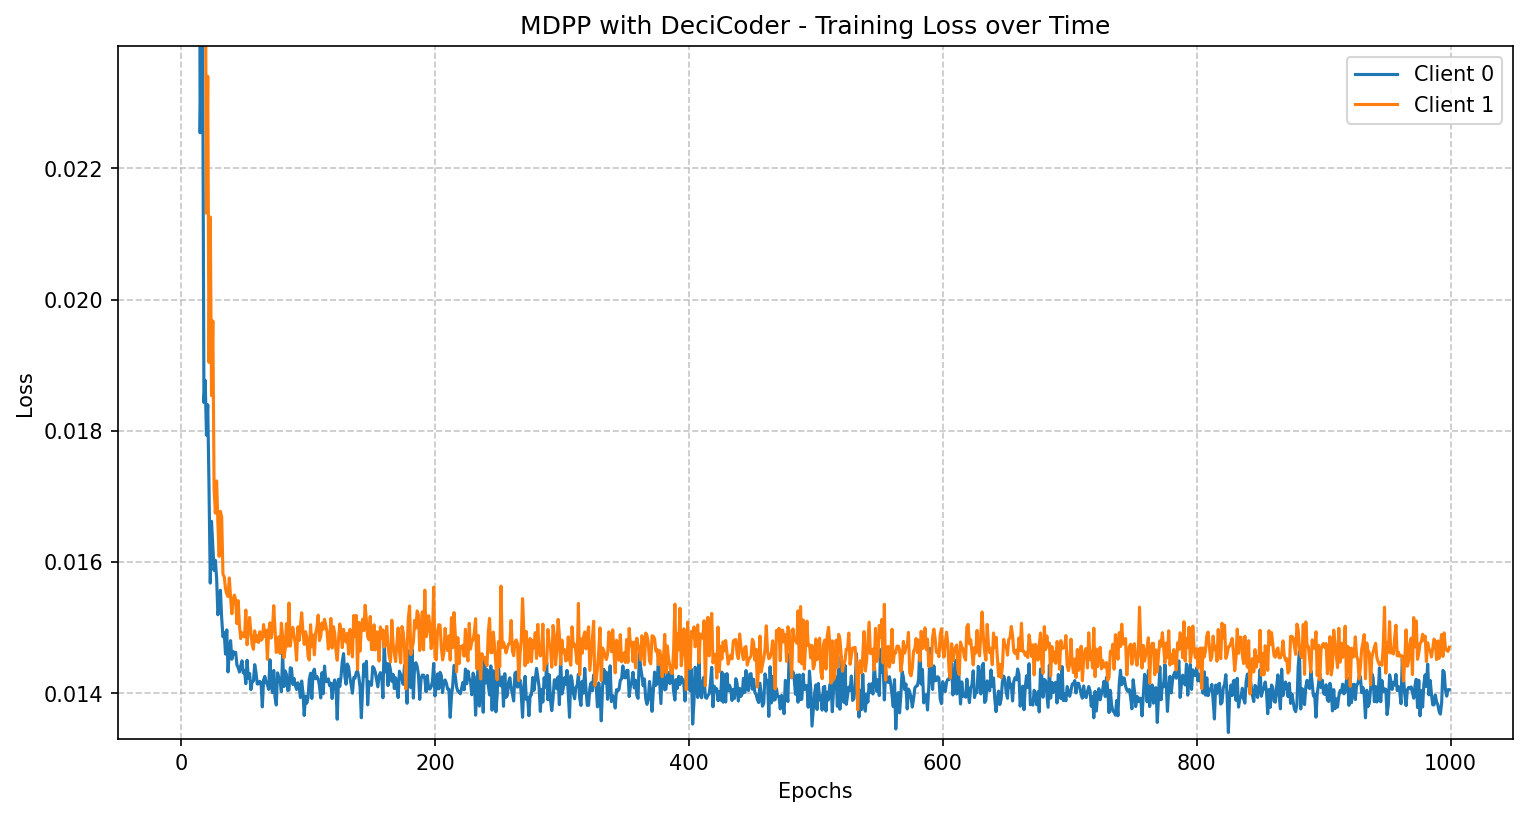

In [9]:
loss_plot("MDPP with DeciCoder - Training Loss over Time", e0, avg0, e1, avg1, (min(all0) - 0.0001, avg0[16]))

In [10]:
# Times to train - won't do for now
import torch

In [11]:
# Divergence in weights from client to initial
def compute_weight_difference(model1, model2):

    # return sum((x1.float() - y1.float()).abs().sum().item() for (x, x1), (y, y1) in zip(model1.named_parameters(), model2.named_parameters()) if type(x1) != str)

    difference = 0.0

    # for (name1, param1), (name2, param2) in zip(model1.state_dict.items(), model2.state_dict.items()):
    count = 0
    for (name1, param1), (name2, param2) in zip(model1.named_parameters(), model2.named_parameters()):
        if isinstance(param1, str) or isinstance(param2, str):
            if not (isinstance(param1, str) and isinstance(param2, str)):
                raise Exception("State Dict not the same! This should not happen.")
            continue

        if param1.data.nelement() != param2.data.nelement():
            raise ValueError(f"Parameters in {name1} and {name2} have different number of elements")

        # print(name1)
        # print(param1.data)
        # print(param2.data)
        # Compute Frobenius norm of the element-wise differences
        count += 1
        diff = torch.norm(param1.data.float() - param2.data.float(), p='fro').item()
        # print(diff)
        difference += diff

    return difference, count

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# Configure hyperparameters for model
from transformers import (
    AutoTokenizer,
    # AutoModelWithLMHead,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    # GenerationConfig,
)

from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

In [14]:
model_name = 'Deci/DeciCoder-1b'

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
# target_modules = ["gate_proj", "up_proj", "down_proj"]
lora_config = LoraConfig(
    r=8,
    target_modules=target_modules,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model_args = {
    'model_name': model_name,
    'tokenizer': tokenizer,
    'datasets_list': None,
    'quant_config': quant_config,
    'lora_config': lora_config
}

tokenizer_config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/777k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/442k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/532 [00:00<?, ?B/s]

In [15]:
def get_model(file_path):
    print(file_path)
    client_model = AutoModelForCausalLM.from_pretrained(
        file_path, quantization_config=quant_config, device_map={"": 0}, trust_remote_code=True
    )
    client_model.gradient_checkpointing_enable()

    client_model = prepare_model_for_kbit_training(client_model)
    client_model = get_peft_model(client_model, lora_config).to(device)
    return client_model

In [16]:
c0 = get_model(SAVE_PATH + "_0")
c1 = get_model(SAVE_PATH + "_1")

./sumanth_setup/checkpoints/deci_model_mbpp_0


config.json:   0%|          | 0.00/715 [00:00<?, ?B/s]

configuration_decicoder.py:   0%|          | 0.00/2.11k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Deci/DeciCoder-1b:
- configuration_decicoder.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_decicoder.py:   0%|          | 0.00/12.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Deci/DeciCoder-1b:
- modeling_decicoder.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

./sumanth_setup/checkpoints/deci_model_mbpp_1


In [17]:
initial_model = get_model(model_name)

Deci/DeciCoder-1b


In [18]:
# Client 0 to initial
a, b = compute_weight_difference(c0, initial_model)
print((a, b))
print(a / b)

(323.3216745853424, 463)
0.6983189515882126


In [19]:
# Client 1 to initial
a, b = compute_weight_difference(c1, initial_model)
print((a, b))
print(a / b)

(323.24350357055664, 463)
0.6981501157031461


In [20]:
# Client 1 to Client 2
a, b = compute_weight_difference(c0, c1)
# print(c0)
print((a, b))
print(a / b)

(323.11579942703247, 463)
0.6978742968186447


In [21]:
a, b = compute_weight_difference(c1, initial_model)
print((a, b))
print(a / b)

(323.24350357055664, 463)
0.6981501157031461


In [22]:
compute_weight_difference(c0, c1)
print((a, b))
print(a / b)

(323.24350357055664, 463)
0.6981501157031461


In [23]:
compute_weight_difference(c1, c1)
print((a, b))
print(a / b)

(323.24350357055664, 463)
0.6981501157031461


In [24]:
print("Number of parameters")
sum(p.numel() for p in initial_model.parameters())

Number of parameters


663398400

In [25]:
def aggregate_weights():

    weight_dict = {}

    for client_idx in range(2):

        # Load client
        quant_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
        )
        client_model = AutoModelForCausalLM.from_pretrained(
            model_name, quantization_config=quant_config, device_map={"": 0}
        )
        client_model.gradient_checkpointing_enable()
        client_model = prepare_model_for_kbit_training(client_model)
        client_model = get_peft_model(client_model, lora_config).to(device)

        # For first model, we have to reset the weights, since dict is originally empty
        for k,v in c0.state_dict().items():
            if isinstance(v, str):
                  weight_dict[k] = v
            else:
                weight_dict[k] = v/torch.tensor(2)

        # For following models, we simply add the weight normalized by number of clients
        for k,v in c1.state_dict().items():
            if isinstance(v, str):
                  weight_dict[k] = v
            else:
                weight_dict[k] += v/torch.tensor(2)

    return weight_dict

In [26]:
global_model = get_model(model_name)
global_model.load_state_dict(aggregate_weights())

Deci/DeciCoder-1b
The repository for Deci/DeciCoder-1b contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/Deci/DeciCoder-1b.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y
The repository for Deci/DeciCoder-1b contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/Deci/DeciCoder-1b.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


<All keys matched successfully>

In [27]:
compute_weight_difference(global_model, initial_model)
print((a, b))
print(a / b)

(323.24350357055664, 463)
0.6981501157031461


In [28]:
compute_weight_difference(global_model, c0)
print((a, b))
print(a / b)

(323.24350357055664, 463)
0.6981501157031461


In [29]:
compute_weight_difference(global_model, c1)
print((a, b))
print(a / b)

(323.24350357055664, 463)
0.6981501157031461
